### A quick demonstration of C-inverse filtering to kappa maps

In [1]:
import numpy as np
import healpy as hp
from matplotlib.pyplot import *
import scipy
import ipywidgets as widgets
import pickle
# from cmblensplus/wrap/
import basic
import curvedsky as cs
# from cmblensplus/utils/
import cmb as CMB
import plottools as pl
import maptools
import constant as c
# others
import local
import tools_multitracer as mass
import warnings
warnings.filterwarnings("ignore")

In [2]:
# define parameters
nside = 512        # CMB map resolution
lmax  = 2*nside     # maximum multipole of alm to be generated
npix = hp.nside2npix(nside)
L = np.linspace(0,lmax,lmax+1)

### Read galaxy survey mask

In [3]:
surveys = ['litebird','cmbs4']
params = local.analysis()

In [4]:
W = {}
W['litebird'] = hp.read_map(params.wind['litebird'])
for survey in surveys:
    if survey == 'litebird': continue
    W[survey] = W['litebird']*hp.read_map(params.wind[survey])

In [5]:
W['lbonly'] = W['litebird']*(1.-W['cmbs4'])

In [6]:
fsky0 = np.average(W['litebird'])
fsky1 = np.average(W['cmbs4'])
fsky2 = np.average(W['lbonly'])
print(fsky0,fsky1,fsky2)

0.48342980941136676 0.22350301717718443 0.25997154857032


In [7]:
nexp = len(surveys)

### Prepare signal map

In [8]:
bl    = np.zeros((nexp,lmax+1))
bl[0] = CMB.beam(30.,lmax,inv=False) 
bl[1] = CMB.beam(3.,lmax,inv=False)

In [9]:
T = hp.read_map(params.ficmb[1],field=0)/c.Tcmb
Q = hp.read_map(params.ficmb[1],field=1)/c.Tcmb
U = hp.read_map(params.ficmb[1],field=2)/c.Tcmb

In [10]:
NSIDE = hp.get_nside(T)
alm  = {}
alm[0] = cs.utils.hp_map2alm(NSIDE,lmax,lmax,T)
alm[1], alm[2] = cs.utils.hp_map2alm_spin(NSIDE,lmax,lmax,2,Q,U)

In [11]:
smap = np.zeros((2,nexp,npix))
smap[0,0,:], smap[1,0,:] = cs.utils.hp_alm2map_spin(nside,lmax,lmax,2,alm[1]*bl[0],alm[2]*bl[0])
smap[0,1,:], smap[1,1,:] = cs.utils.hp_alm2map_spin(nside,lmax,lmax,2,alm[1]*bl[1],alm[2]*bl[1])

### Prepare noise map

In [12]:
Ncov = np.zeros((4,4,lmax+1))
Ncov[0,0,:] = Ncov[1,1,:] = (2.*c.ac2rad/c.Tcmb)**2
Ncov[2,2,:] = Ncov[3,3,:] = (1.*c.ac2rad/c.Tcmb)**2 

In [13]:
nlm = cs.utils.gaussalm(Ncov)

In [14]:
nmap = np.zeros((2,nexp,npix))
nmap[0,0,:], nmap[1,0,:] = cs.utils.hp_alm2map_spin(nside,lmax,lmax,2,nlm[0],nlm[1])
nmap[0,1,:], nmap[1,1,:] = cs.utils.hp_alm2map_spin(nside,lmax,lmax,2,nlm[2],nlm[3])

### Optimally coadded kappa map

In [15]:
invN = np.zeros((2,nexp,npix))
#inls = np.zeros((2,nmap,lmax+1))
#invN[:,0,:] = W['litebird']/Ncov[0,0,0]
invN[:,0,:] = W['cmbs4']/Ncov[0,0,0]
invN[:,1,:] = W['cmbs4']/Ncov[2,2,0]
#invN[:,0,:] = W['lbonly']/Ncov[0,0,0]
#invN[:,1,:] = W['lbonly']/Ncov[2,2,0]

In [16]:
# observed cmb maps
omap = smap + nmap
#omap[:,0,:] *= W['litebird']
omap[:,0,:] *= W['cmbs4']
omap[:,1,:] *= W['cmbs4']
#omap[:,0,:] *= W['lbonly']
#omap[:,1,:] *= W['lbonly']

In [17]:
elm, blm = cs.utils.hp_map2alm_spin(nside,lmax,lmax,2,omap[0,0,:],omap[1,0,:])
#elm, blm = cs.utils.hp_map2alm_spin(nside,lmax,lmax,2,omap[0,1,:],omap[1,1,:])

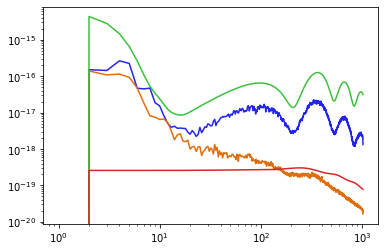

In [18]:
loglog(L,cs.utils.alm2cl(lmax,elm))
loglog(L,cs.utils.alm2cl(lmax,blm))
loglog(L,params.lcl[1,:lmax+1])
loglog(L,params.lcl[2,:lmax+1])

In [19]:
# Computing filtered-alms
wElm, wBlm = cs.cninv.cnfilter_freq(2,nexp,nside,lmax,params.lcl[1:3,:lmax+1],bl,invN,omap,chn=1,itns=[1000],eps=[1e-5],ro=10,stat='status.txt')

In [20]:
wEmap = cs.utils.hp_alm2map(nside,lmax,lmax,wElm)

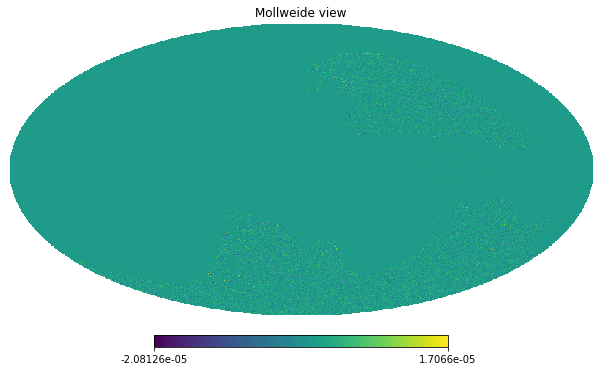

In [21]:
hp.mollview(wEmap)

In [22]:
klm = {}
rlz = 1
klm[0], klm[1], klm[2], klm[3] = pickle.load(open(local.data_directory()['mas'] + 'alm/coadd_mass_'+str(rlz)+'.pkl',"rb"))

In [23]:
elmin, elmax, klmin, klmax = 2, lmax, 2, lmax

In [24]:
blm, Blm = {}, {}
for i in range(4):
    blm[i] = cs.delens.lensingb( lmax, elmin, elmax, klmin, klmax, alm[1], klm[i], gtype='k')
    Blm[i] = cs.delens.lensingb( lmax, elmin, elmax, klmin, klmax, wElm, klm[i], gtype='k')

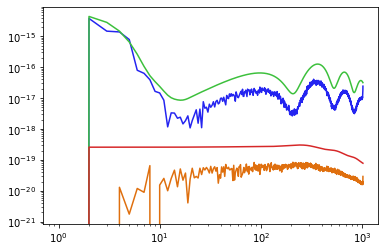

In [25]:
loglog(L,cs.utils.alm2cl(lmax,alm[1],wElm))
loglog(L,cs.utils.alm2cl(lmax,alm[2],wBlm))
loglog(L,params.lcl[1,:lmax+1])
loglog(L,params.lcl[2,:lmax+1])

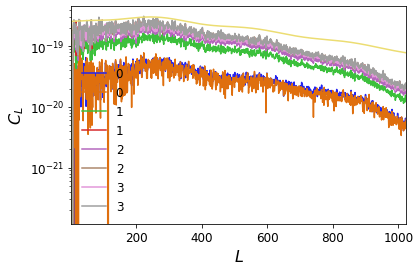

In [26]:
pl.plot_1dstyle(ylog=True,xmin=2,xmax=lmax)
for i in range(4):
    plot(L,cs.utils.alm2cl(lmax,alm[2],blm[i])/fsky0,label=i)
    plot(L,cs.utils.alm2cl(lmax,alm[2],Blm[i])/fsky2,label=i)
plot(L,params.lcl[2,:lmax+1])
legend()
show()

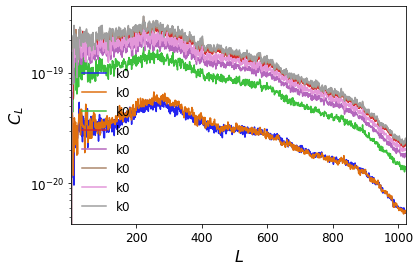

In [27]:
pl.plot_1dstyle(ylog=True,xmin=2,xmax=lmax)
for i in range(4):
    plot(L,cs.utils.alm2cl(lmax,blm[i])/fsky0,label='k0')
    plot(L,cs.utils.alm2cl(lmax,Blm[i])/fsky2,label='k0')
legend()
show()

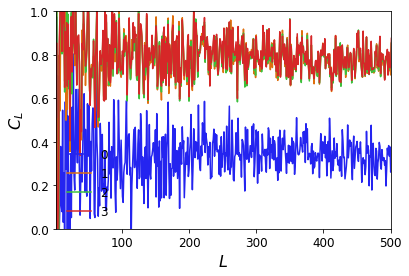

In [28]:
pl.plot_1dstyle(xmin=2,xmax=500,ymin=0,ymax=1)
clbb = cs.utils.alm2cl(lmax,alm[2])
for i in range(4):
    #plot(L,cs.utils.alm2cl(lmax,alm[2],blm[i])/fsky0/np.sqrt(cs.utils.alm2cl(lmax,blm[i])/fsky0*clbb),label=i)
    plot(L,cs.utils.alm2cl(lmax,alm[2],Blm[i])/fsky2/np.sqrt(cs.utils.alm2cl(lmax,Blm[i])/fsky2*clbb),label=i)
legend()
show()

In [29]:
bmap = {i: cs.utils.hp_alm2map(nside,lmax,lmax,Blm[i]) for i in range(4)}

In [30]:
pl.view_maps(bmap)

map key list: [0, 1, 2, 3]


NameError: name 'ibmap' is not defined

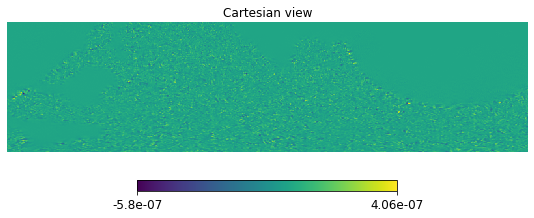

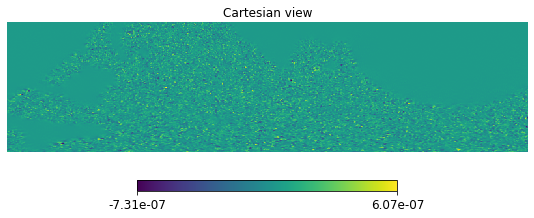

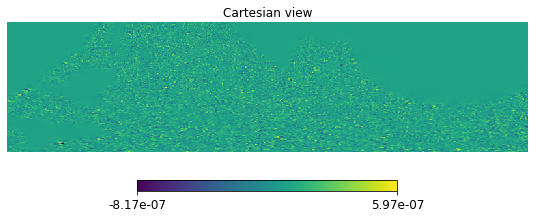

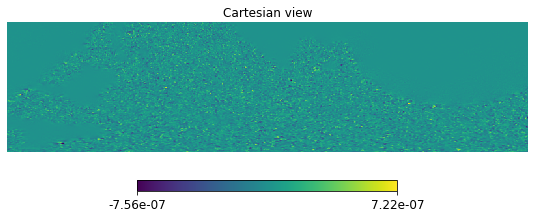

In [31]:
lonra, latra = [-80,80], [-70,-30]
for i in range(4):
    hp.cartview(bmap[i],lonra=lonra,latra=latra)
hp.cartview(ibmap,lonra=lonra,latra=latra)